In [2]:
from process_childes import extract_utterances_by_age_and_adult_folder, clean_chinese_utterances_simple
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the data
data = clean_chinese_utterances_simple(extract_utterances_by_age_and_adult_folder("Mandarin"))

In [4]:
model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

In [5]:
target_chars = {"把", "被", "給"}

# Filter child utterances by age
filtered_by_age = {
    age: [utt for utt in utts if any(char in utt for char in target_chars)]
    for age, utts in data["child"].items()
    if utts
}

# Filter adult utterances
filtered_by_age["adult"] = [
    utt for utt in data["adult"] if any(char in utt for char in target_chars)
]


In [6]:
for group, utts in filtered_by_age.items():
    print(group, len(utts))

4 1747
5 2983
6 2674
3 1527
2 683
7 683
8 158
9 86
10 68
1 92
0 18
adult 18612


In [9]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertModel.from_pretrained("bert-base-chinese")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [12]:
def get_character_embeddings_by_group(data, target_chars):
    from transformers import BertTokenizer, BertModel
    import torch

    tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
    model = BertModel.from_pretrained("bert-base-chinese")

    result = {}

    for group, utterances in data.items():
        group_result = {char: [] for char in target_chars}
        for utt in utterances:
            if not isinstance(utt, str):
                continue
            if not any(char in utt for char in target_chars):
                continue
            inputs = tokenizer(utt, return_tensors="pt")
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.squeeze(0)  # (seq_len, hidden_size)

            tokens = tokenizer.tokenize(utt)
            for i, token in enumerate(tokens):
                for char in target_chars:
                    if token == char:
                        group_result[char].append(embeddings[i].detach().numpy())
        result[group] = group_result

    return result


In [13]:
target_chars = ["把", "被", "給"]

char_embeddings_by_group = get_character_embeddings_by_group(data, target_chars)

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [14]:
import os
import pickle

output_dir = "char_embeddings_by_group"
os.makedirs(output_dir, exist_ok=True)

for char, groups in char_embeddings_by_group.items():
    for group, vectors in groups.items():
        filename = f"{output_dir}/{char}_{group}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(vectors, f)


In [15]:
from sklearn.decomposition import PCA
import numpy as np

def reduce_embeddings(embeddings, n_components=2):
    all_vectors = np.vstack(embeddings)
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(all_vectors)
    return reduced


In [16]:
# Flatten all embeddings to reduce them together
group_labels = []
char_labels = []
vectors = []

for group, chars in char_embeddings_by_group.items():
    for char, embs in chars.items():
        for emb in embs:
            vectors.append(emb)
            group_labels.append(group)
            char_labels.append(char)

# Reduce to 2D
reduced_vectors = reduce_embeddings(vectors)


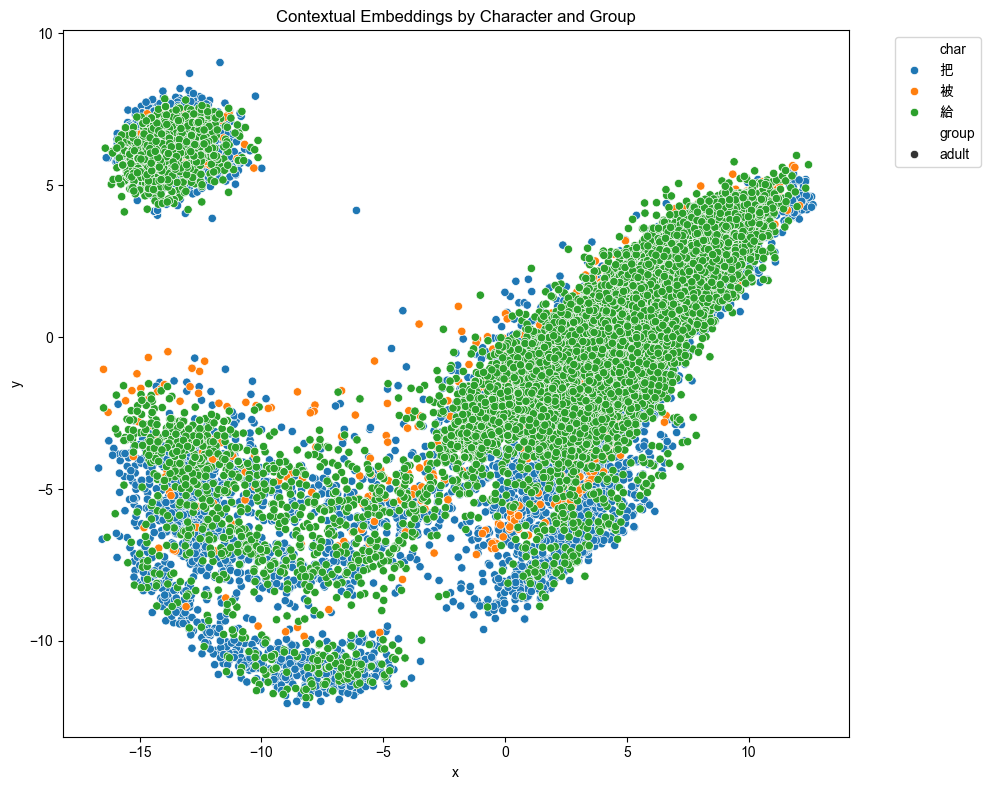

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Chinese characters display correctly
plt.rcParams["font.family"] = "Arial Unicode MS"  # or another font that supports Chinese

def plot_reduced_embeddings(reduced_vectors, group_labels, char_labels):
    plt.figure(figsize=(10, 8))
    df = {
        "x": [vec[0] for vec in reduced_vectors],
        "y": [vec[1] for vec in reduced_vectors],
        "group": group_labels,
        "char": char_labels
    }
    sns.scatterplot(x="x", y="y", hue="char", style="group", data=df)
    plt.title("Contextual Embeddings by Character and Group")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_reduced_embeddings(reduced_vectors, group_labels, char_labels)


In [20]:
char_embeddings_by_group.keys()

dict_keys(['child', 'adult'])

In [22]:
char_embeddings_by_group['child']

{'把': [], '被': [], '給': []}

In [1]:
def get_character_embeddings_by_group(data, target_chars):
    import torch
    from transformers import BertTokenizer, BertModel

    tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
    model = BertModel.from_pretrained("bert-base-chinese")
    model.eval()

    result = {"child": {}, "adult": {}}

    # For children: data["child"] is dict {age: list of (utt, gra)}
    for age, utterances in data["child"].items():
    group_result = {char: [] for char in target_chars}
    for utt in utterances:  # no unpacking, just utt string
        for char in target_chars:
            if char in utt:
                inputs = tokenizer(utt, return_tensors="pt", truncation=True, max_length=512)
                with torch.no_grad():
                    outputs = model(**inputs)
                embeddings = outputs.last_hidden_state.squeeze(0)
                tokens = tokenizer.tokenize(utt)
                positions = [i for i, token in enumerate(tokens) if char in token]
                for pos in positions:
                    group_result[char].append(embeddings[pos].numpy())
    result["child"][age] = group_result

    group_result = {char: [] for char in target_chars}
    for utt in data["adult"]:
        for char in target_chars:
            if char in utt:
                inputs = tokenizer(utt, return_tensors="pt", truncation=True, max_length=512)
                with torch.no_grad():
                    outputs = model(**inputs)
                embeddings = outputs.last_hidden_state.squeeze(0)
                tokens = tokenizer.tokenize(utt)
                positions = [i for i, token in enumerate(tokens) if char in token]
                for pos in positions:
                    group_result[char].append(embeddings[pos].numpy())
    result["adult"] = group_result


    return result

# Run with your data:
char_embeddings_by_group = get_character_embeddings_by_group(data, ["把", "被", "給"])


IndentationError: expected an indented block after 'for' statement on line 12 (137553643.py, line 13)

In [24]:
# Summarize embeddings count
def summarize_embeddings(embeddings_by_group):
    for group in embeddings_by_group:
        print(f"Group: {group}")
        if group == "child":
            for age in sorted(embeddings_by_group[group]):
                print(f"  Age {age}:")
                for char, embeds in embeddings_by_group[group][age].items():
                    print(f"    {char}: {len(embeds)} embeddings")
        else:
            for char, embeds in embeddings_by_group[group].items():
                print(f"  {char}: {len(embeds)} embeddings")

summarize_embeddings(char_embeddings_by_group)


Group: child
  Age 把:


AttributeError: 'list' object has no attribute 'items'